<a href="https://colab.research.google.com/github/SreeSajeev/FakeNewsDetector/blob/main/fakenewsdetector-new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/SreeSajeev/FakeNewsDetector/refs/heads/main/news.csv')


In [3]:
print(df.head())
print(df.info())


   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 

In [4]:
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:

# Drop Unnamed column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [6]:
# Merge title + text into full_text
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

In [7]:

# Preview
print(df[['title', 'text', 'label']].head())

                                               title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


In [8]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['full_text'].apply(clean_text)


In [9]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['clean_text'] = df['clean_text'].apply(remove_stopwords)


In [10]:
# If not already binary: 'FAKE' → 0, 'REAL' → 1
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})


In [11]:
print(df[['clean_text', 'label']].head())
print(df['label'].value_counts())  # Check balance


                                          clean_text  label
0  smell hillarys fear daniel greenfield shillman...      0
1  watch exact moment paul ryan committed politic...      0
2  kerry go paris gesture sympathy us secretary s...      1
3  bernie supporters twitter erupt anger dnc trie...      0
4  battle new york primary matters primary day ne...      1
label
1    3171
0    3164
Name: count, dtype: int64


In [12]:
#Train a baseline model using TF-IDF + Logistic Regression
#Train-Test Split
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [13]:
#TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [14]:
#Train a Classifier (Logistic Regression)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9194948697711128
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       633
           1       0.94      0.90      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



In [16]:
## Get top contributing words
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

top_fake = np.argsort(coefficients)[-10:]
top_real = np.argsort(coefficients)[:10]

print("🔴 Top 'FAKE' indicators:")
for i in top_fake:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

print("\n🟢 Top 'REAL' indicators:")
for i in top_real:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")


🔴 Top 'FAKE' indicators:
fox: 2.0676
islamic: 2.1220
state: 2.1244
debate: 2.2987
president: 2.3135
sanders: 2.4158
candidates: 2.5348
cruz: 2.6974
gop: 2.7603
said: 6.5657

🟢 Top 'REAL' indicators:
october: -4.5846
hillary: -3.8740
election: -2.8191
november: -2.8144
article: -2.4693
share: -2.4429
source: -2.2534
fbi: -2.2327
russia: -2.2177
wikileaks: -1.9616


In [17]:
#Create a Prediction + Explanation Function
import numpy as np

def explain_prediction(text, model, vectorizer, top_n=10):
    # Vectorize the input text
    vec = vectorizer.transform([text])
    prediction = model.predict(vec)[0]
    proba = model.predict_proba(vec)[0]

    # Get feature importance
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.coef_[0]

    # Multiply TF-IDF weights by model coefficients
    scores = vec.toarray()[0] * coefs
    word_score_pairs = [
        (feature_names[i], scores[i])
        for i in range(len(scores)) if scores[i] != 0
    ]

    word_score_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
    top_words = word_score_pairs[:top_n]

    return {
        'prediction': prediction,
        'confidence': round(np.max(proba), 2),
        'top_words': top_words
    }


In [18]:
sample_text = "Hillary Clinton was under FBI investigation during the elections."
result = explain_prediction(sample_text, model, tfidf)

print(f"Prediction: {result['prediction']} ({result['confidence'] * 100:.2f}%)")
print("Top Influential Words:")
for word, score in result['top_words']:
    print(f"{word}: {score:.4f}")


Prediction: 0 (99.00%)
Top Influential Words:
hillary: -1.2341
fbi: -1.1699
investigation: -0.4690
elections: -0.3324
clinton: 0.0928


#Dynamic Misinformation Narrative Tracking & Visualization

In [19]:
# Install all required libraries
!pip install pandas numpy spacy scikit-learn plotly pyvis \
            sentence-transformers yake networkx \
            transformers shap matplotlib

# Download spaCy English model
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [20]:
import pandas as pd
import numpy as np
import spacy
import sklearn
import plotly
import pyvis
from sentence_transformers import SentenceTransformer
import yake
import networkx as nx
from transformers import pipeline
import shap
import matplotlib.pyplot as plt


In [21]:
nlp = spacy.load("en_core_web_sm")


In [22]:
texts = df['text'].dropna().tolist()
processed_docs = list(nlp.pipe((text.lower() for text in texts), batch_size=50, n_process=-1))

In [23]:
import yake

kw_extractor = yake.KeywordExtractor(top=10, lan="en", n=1)
keywords = [kw_extractor.extract_keywords(text) for text in texts]

In [24]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Batches:   0%|          | 0/198 [00:00<?, ?it/s]

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, df['label'], test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)


RandomForestClassifier()

<Figure size 640x480 with 0 Axes>

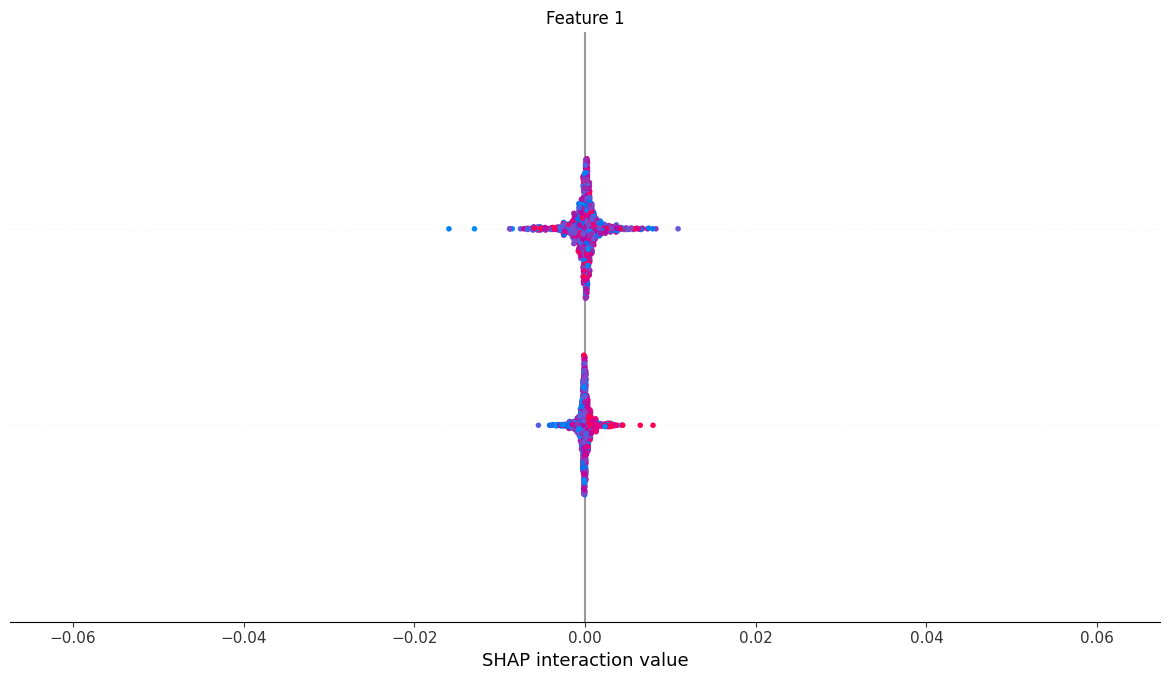

In [26]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

# Visualize
shap.summary_plot(shap_values, features=X_test)


In [27]:
from pyvis.network import Network
import networkx as nx
import numpy as np
from pyvis.network import Network
import networkx as nx
import numpy as np


In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Step 2: Build graph from similarity matrix
G = nx.Graph()

# Limit number of documents for clarity in visualization (optional)
doc_limit = 50
similarity_threshold = 0.6  # You can tweak this

for i in range(doc_limit):
    for j in range(i + 1, doc_limit):
        sim = similarity_matrix[i][j]
        if sim > similarity_threshold:
            G.add_edge(f'Doc {i}', f'Doc {j}', weight=sim)

print(f"Number of nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")


Number of nodes: 8, edges: 4


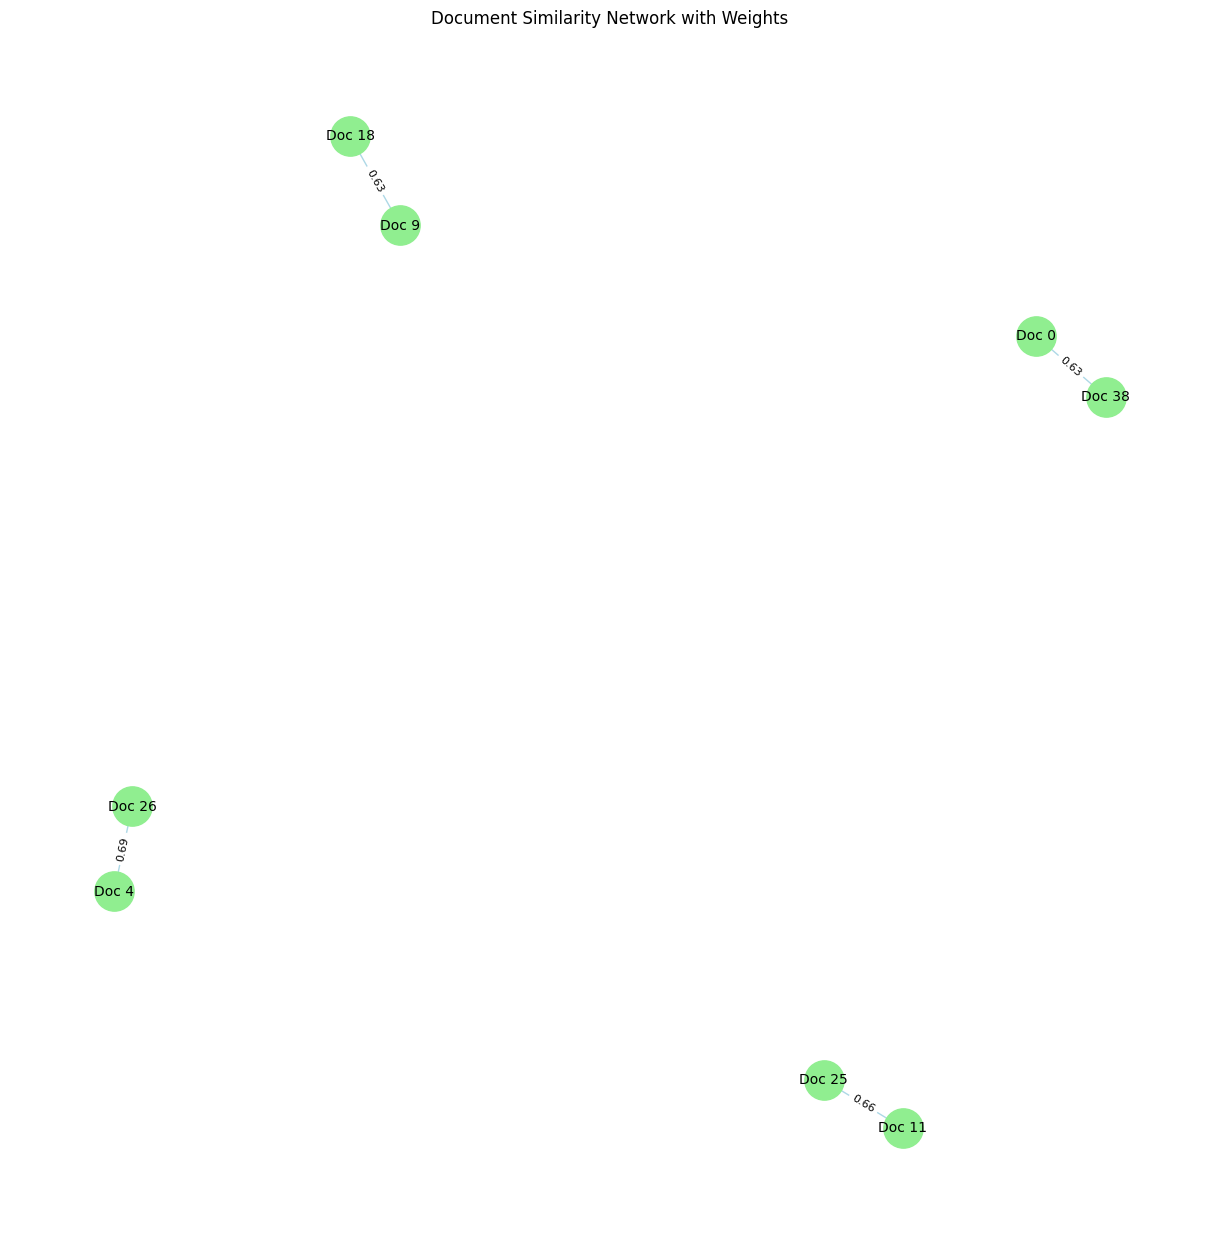

In [32]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, font_size=10,
        edge_color='lightblue', node_color='lightgreen', font_color='black')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_size=8)
plt.title("Document Similarity Network with Weights")
plt.axis('off')
plt.show()


In [36]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Limit number of documents to visualize for clarity
doc_limit = 100
similarity_threshold = 0.7

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings[:doc_limit])

# Create graph
G = nx.Graph()

# Add nodes
for i in range(doc_limit):
    G.add_node(f'Doc {i}', label=df['label'].iloc[i])  # Store label for coloring later

# Add edges for similar documents
for i in range(doc_limit):
    for j in range(i + 1, doc_limit):
        sim = float(similarity_matrix[i][j])
        if sim > similarity_threshold:
            G.add_edge(f'Doc {i}', f'Doc {j}', weight=sim)


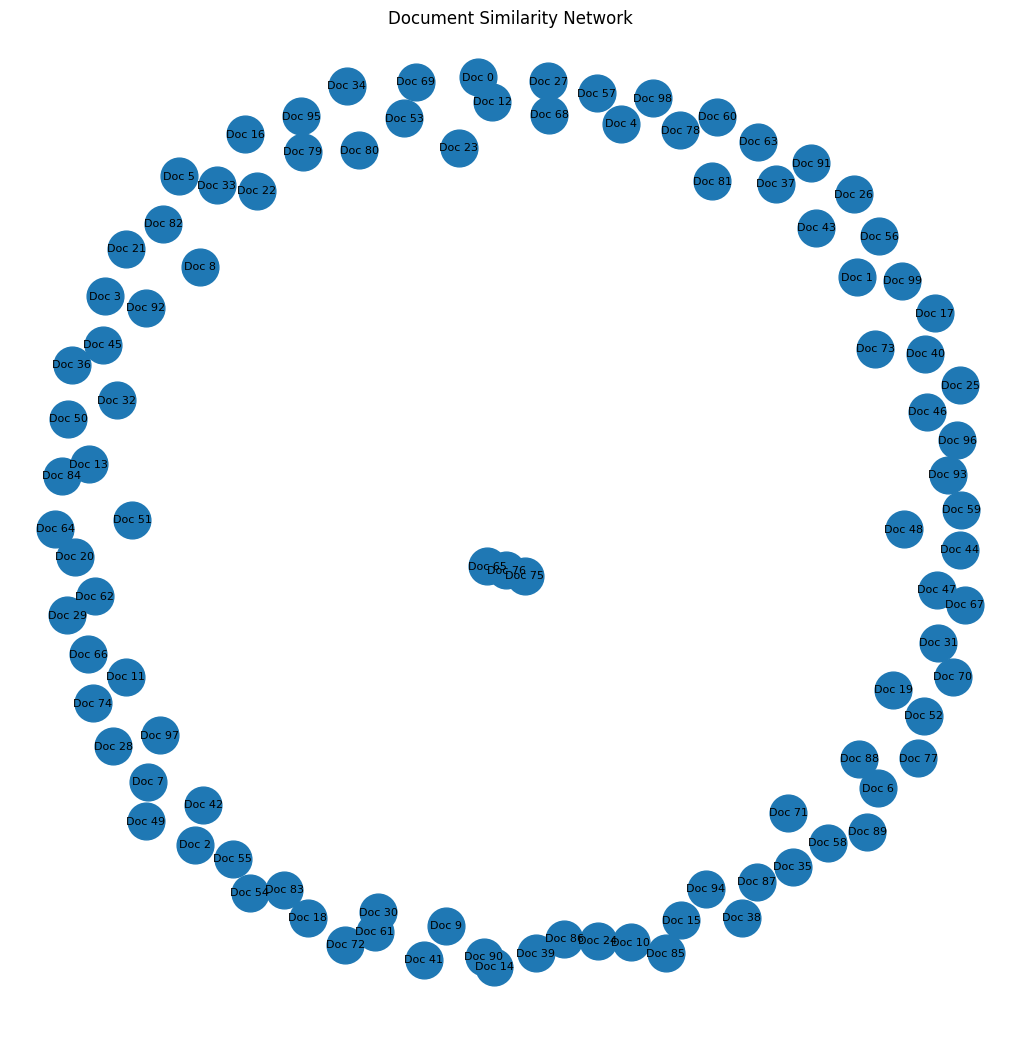

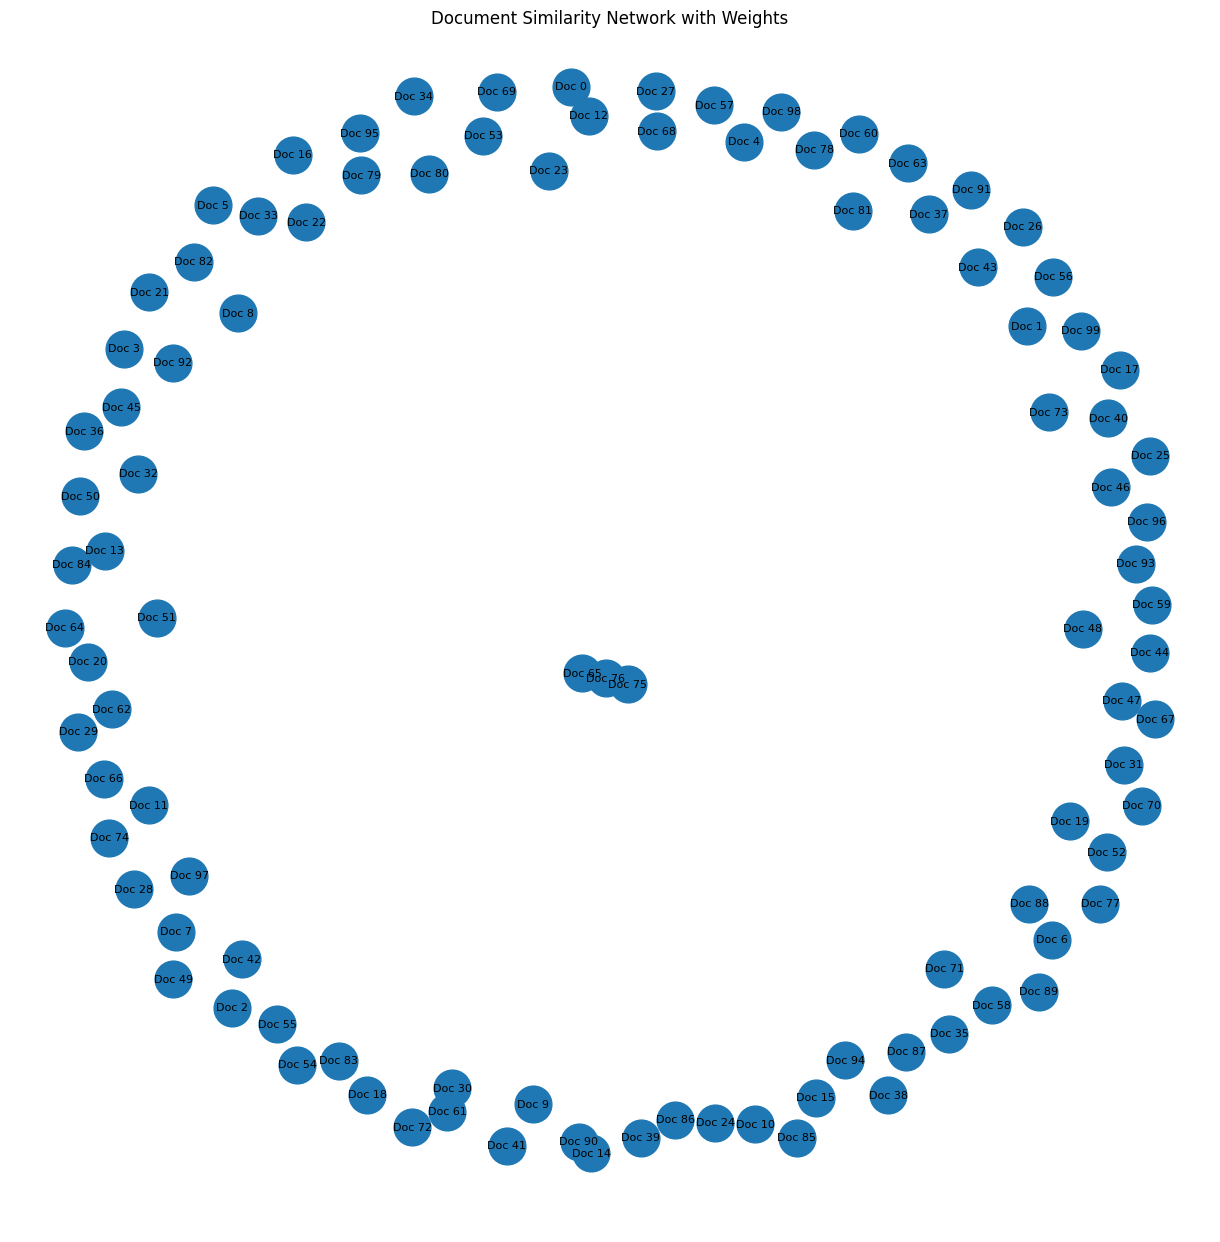

In [37]:
import matplotlib.pyplot as plt

# Basic network
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=700, font_size=8, edge_color='gray')
plt.title("Document Similarity Network")
plt.show()

# With weights
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=700, font_size=8, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_size=7)
plt.title("Document Similarity Network with Weights")
plt.show()


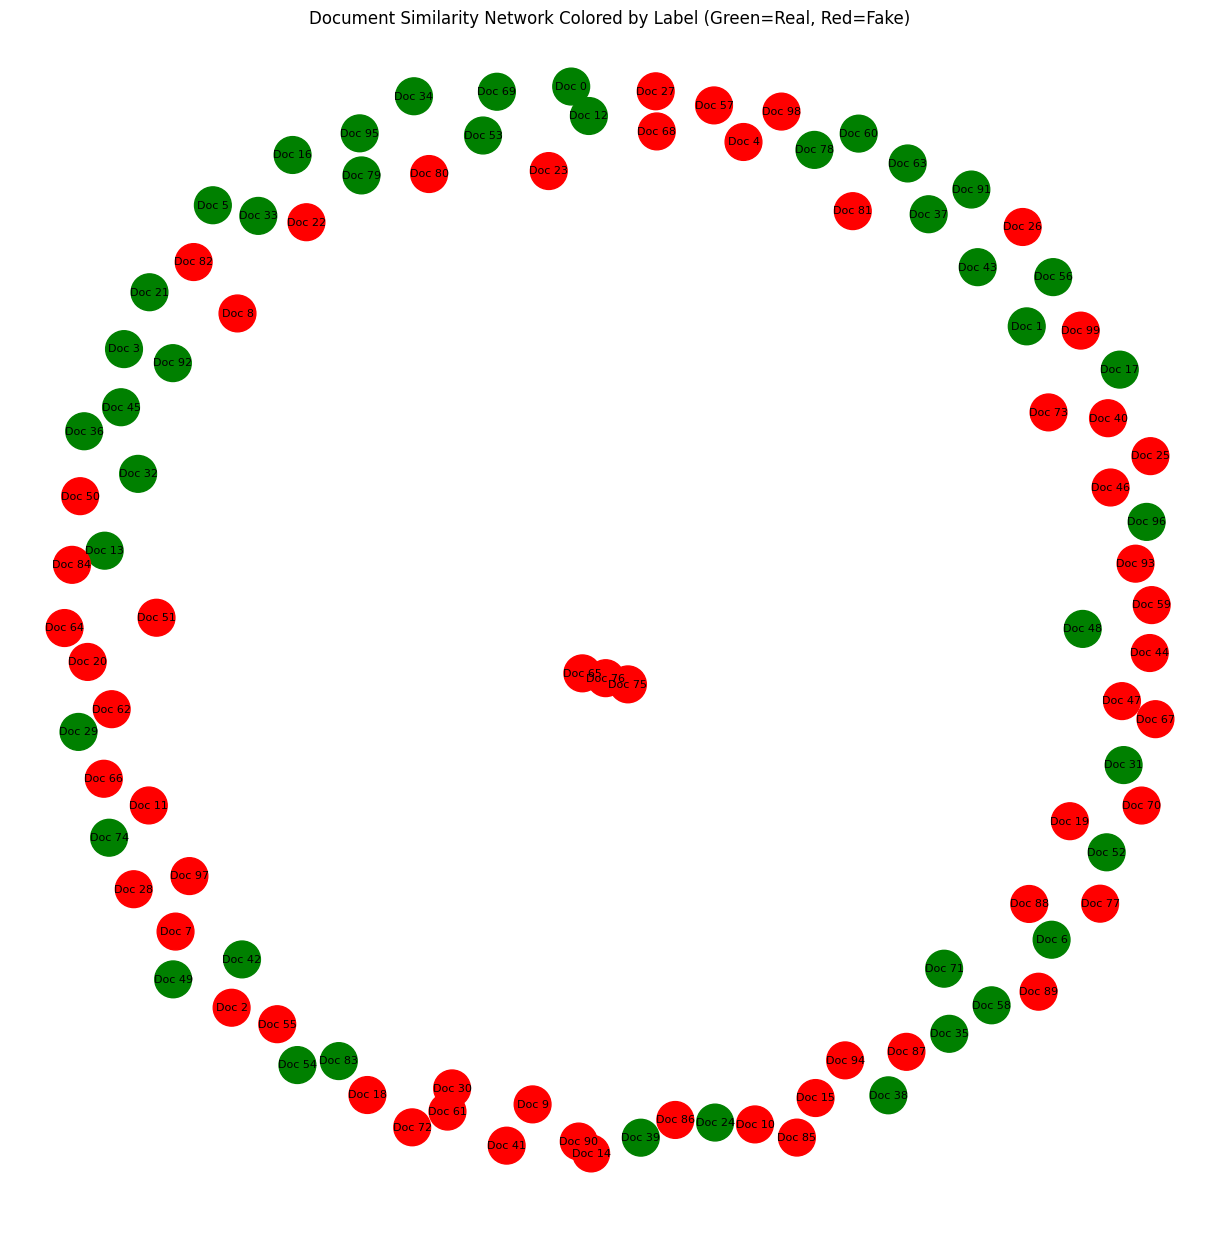

In [38]:
# Map labels to colors
label_colors = {0: 'green', 1: 'red'}  # 0 = Real, 1 = Fake

node_colors = [label_colors[G.nodes[node]['label']] for node in G.nodes]

plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=700, font_size=8, node_color=node_colors, edge_color='gray')
plt.title("Document Similarity Network Colored by Label (Green=Real, Red=Fake)")
plt.show()


In [40]:
import plotly.graph_objects as go
import networkx as nx

# Create positions using spring layout
pos = nx.spring_layout(G, seed=42)

# Extract edges and weights
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Extract nodes
node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(str(node))  # or df.iloc[node]["title"]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=node_text,
    textposition="top center",
    marker=dict(
        showscale=False,
        color='lightblue',
        size=10,
        line_width=2
    )
)

# Combine and show
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Document Similarity Network',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))
fig.show()


In [41]:
def preprocess(doc):
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
processed_texts = [preprocess(doc) for doc in processed_docs]


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np

similarity_matrix = cosine_similarity(embeddings)
threshold = 0.7  # adjust based on density you want

G = nx.Graph()

# Add nodes with labels
for i, label in enumerate(df['label']):
    G.add_node(i, label=label)

# Add edges for similarities above threshold
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        weight = similarity_matrix[i][j]
        if weight > threshold:
            G.add_edge(i, j, weight=float(weight))


In [47]:
import plotly.graph_objects as go

# Define label colors for numeric labels
label_colors = {0: 'red', 1: 'green'}

# Layout and colors
pos = nx.spring_layout(G, seed=42)
edge_x, edge_y = [], []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines')

# Node positions and labels
node_x, node_y, node_text, node_color = [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    label = G.nodes[node].get('label', 'UNKNOWN')
    label_str = 'FAKE' if label == 0 else ('REAL' if label == 1 else 'UNKNOWN')
    node_text.append(f'Doc {node} ({label_str})')
    node_color.append(label_colors.get(label, 'blue'))  # fallback color blue

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=[str(i) for i in G.nodes()],
    marker=dict(
        showscale=False,
        color=node_color,
        size=10,
        line_width=2),
    hovertext=node_text,
    hoverinfo='text')

# Build final figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Document Similarity Network',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


In [48]:
import plotly.graph_objects as go
import networkx as nx

# Assuming G is your networkx graph with 'label' attribute on each node (0=FAKE, 1=REAL)
# and 'weight' attribute on edges

# Define colors and marker symbols for each label
label_info = {
    0: {'color': 'red', 'symbol': 'circle', 'name': 'FAKE'},
    1: {'color': 'green', 'symbol': 'square', 'name': 'REAL'}
}

# Get positions for nodes
pos = nx.spring_layout(G, seed=42)

# Prepare edges data with hover info showing weights
edge_x, edge_y = [], []
edge_text = []
for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    weight = data.get('weight', 1)
    edge_text.append(f"Weight: {weight:.2f}")

# Edge trace
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='text',
    text=edge_text * 2,  # Repeat for both nodes of edge
    mode='lines'
)

# Prepare nodes by label groups for separate traces (for legend and shapes)
node_traces = []
for label, info in label_info.items():
    node_x, node_y, node_text = [], [], []
    for node in G.nodes():
        if G.nodes[node].get('label') == label:
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_text.append(f"Doc {node} ({info['name']})")
    trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        name=info['name'],
        text=[str(i) for i, n in enumerate(node_x)],  # optional: node index or id
        marker=dict(
            color=info['color'],
            size=15,
            symbol=info['symbol'],
            line=dict(width=2, color='black')
        ),
        hoverinfo='text',
        hovertext=node_text,
        textposition="top center"
    )
    node_traces.append(trace)

# Combine everything into a figure
fig = go.Figure(data=[edge_trace] + node_traces)

fig.update_layout(
    title="Document Similarity Network",
    showlegend=True,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    legend=dict(
        x=0.85,
        y=0.95,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    )
)

fig.show()


In [49]:
import pandas as pd

# Example: get top 3 similar docs for each doc based on edge weights
top_k = 3
rows = []
for node in G.nodes():
    neighbors = [(nbr, G.edges[node, nbr]['weight']) for nbr in G.neighbors(node)]
    neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)[:top_k]
    for nbr, weight in neighbors:
        rows.append({'Doc': node, 'Similar Doc': nbr, 'Similarity': weight})

df_sim = pd.DataFrame(rows)
df_sim.head()


Doc  Similar Doc  Similarity
0    0         3432    0.803461
1    0         2977    0.771349
2    0         3132    0.765402
3    1         1003    0.743565
4    1         3396    0.736010

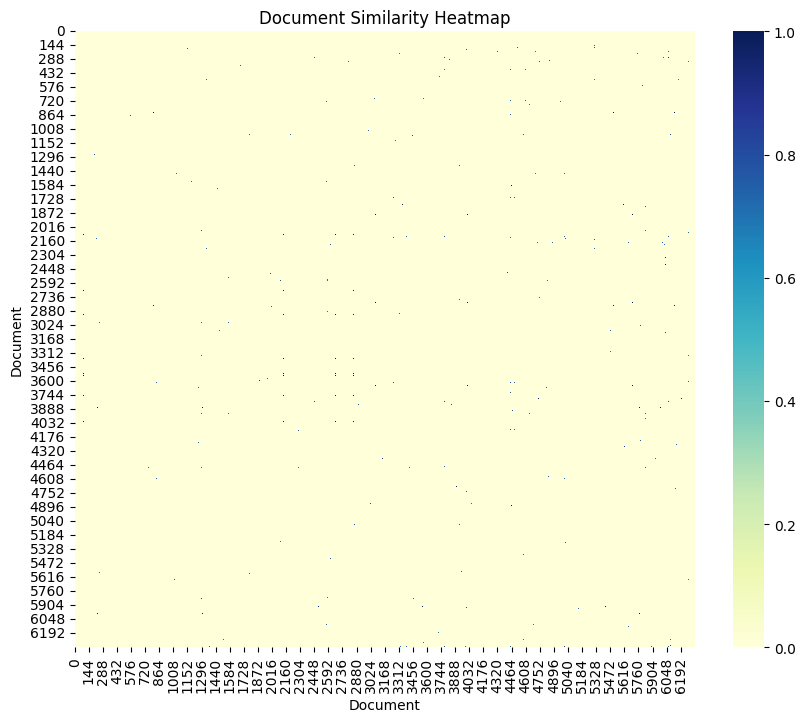

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create similarity matrix from graph edges
n = len(G.nodes)
sim_matrix = np.zeros((n, n))
for u, v, data in G.edges(data=True):
    sim_matrix[u][v] = data['weight']
    sim_matrix[v][u] = data['weight']  # if undirected

plt.figure(figsize=(10,8))
sns.heatmap(sim_matrix, cmap="YlGnBu")
plt.title("Document Similarity Heatmap")
plt.xlabel("Document")
plt.ylabel("Document")
plt.show()


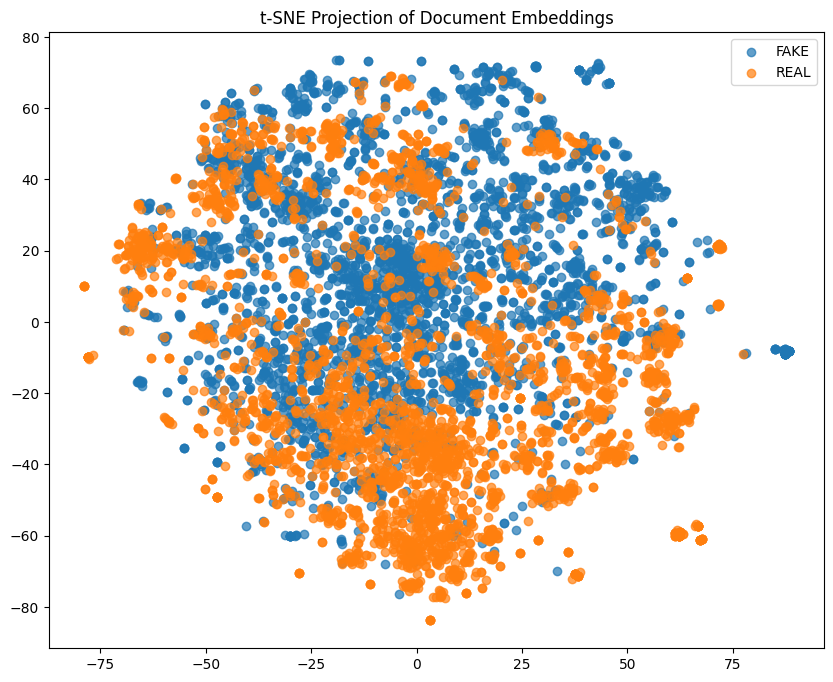

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

labels = df['label'].map({0:'FAKE', 1:'REAL'})

plt.figure(figsize=(10, 8))
for label in labels.unique():
    idx = labels == label
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1],
                label=label, alpha=0.7)
plt.legend()
plt.title("t-SNE Projection of Document Embeddings")
plt.show()
